In [1]:
import pandas as pd
import numpy as np
from numpy import load
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy.linalg import norm


In [2]:
### import data from csv (written in data_processing)
q_array = load('q_array.npy')
a_array = load('a_array.npy')

### find number of trials
data_trials = int(a_array.shape[0])

In [3]:
### organize data into training and test tensors
train_x = (q_array[0:int(0.8*data_trials),:,:]).astype(np.float32) # training data from csv/pandas (80% of existing data?)
x_train_tensor = torch.from_numpy(train_x)
test_x = (q_array[int(0.8*data_trials):data_trials,:,:]).astype(np.float32) # test data from csv/pandas (remaining ~20% of data)
test_x = np.expand_dims(test_x, 1) # add dimension for neural net
x_test_tensor = torch.from_numpy(test_x)

train_y = (a_array[0:int(0.8*data_trials),:]).astype(np.float32)
y_train_tensor = torch.from_numpy(train_y)
test_y = (a_array[int(0.8*data_trials):data_trials,:]).astype(np.float32)
y_test_tensor = torch.from_numpy(test_y)

test_data = [(x_test_tensor[i],y_test_tensor[i]) for i in range(x_test_tensor.shape[0])]


train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 1000, shuffle=True)


for batch, (x, y) in enumerate(train_loader):
    print("batch", batch)
    print("Shape of x: ", x.shape, x.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break

batch 0
Shape of x:  torch.Size([1000, 16, 100]) torch.float32
Shape of y:  torch.Size([1000, 6]) torch.float32


In [4]:
### define model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
            
        self.ls = nn.LSTM(16,32,2, batch_first = True)
        self.linear = nn.Linear(32,6)
            

    def forward(self, x):
        batch_size = x.shape[0] 
        x = self.flatten(x)
        x = torch.reshape(x, (batch_size, 100, 16)) 
        output,(h,c) = self.ls(x)
        output = self.linear(h[-1,...]) 
        return nn.Sigmoid()(output)

model = Net()
print(model)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (ls): LSTM(16, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=6, bias=True)
)


In [5]:
### loss function and optimizer for training 
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

### Functions for training and testing the model
def train(dataloader, model, loss_fn, optimizer,loss_list):
    size = len(dataloader.dataset)
    for batch, (x,y) in enumerate(dataloader):

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(x)
            loss_list.append(loss)
        if batch % 20 == 0:
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list

def test(dataloader, model,test_loss_list):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y)
    print(f"Test Error: Loss = {test_loss:>8f} \n")
    test_loss_list.append(test_loss)
    return test_loss_list

In [6]:
### Train the model
epochs = 800
loss_list=[]
test_loss_list=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_list = train(train_loader, model, loss_fn, optimizer,loss_list)
    test_loss_list = test(test_loader, model, test_loss_list)

Epoch 1
-------------------------------
loss: 0.083629  [    0/16396]
Test Error: Loss = 0.420287 

Epoch 2
-------------------------------
loss: 0.083704  [    0/16396]
Test Error: Loss = 0.359979 

Epoch 3
-------------------------------
loss: 0.069956  [    0/16396]
Test Error: Loss = 0.353394 

Epoch 4
-------------------------------
loss: 0.068659  [    0/16396]
Test Error: Loss = 0.342998 

Epoch 5
-------------------------------
loss: 0.068005  [    0/16396]
Test Error: Loss = 0.299234 

Epoch 6
-------------------------------
loss: 0.058489  [    0/16396]
Test Error: Loss = 0.282964 

Epoch 7
-------------------------------
loss: 0.055915  [    0/16396]
Test Error: Loss = 0.283398 

Epoch 8
-------------------------------
loss: 0.056693  [    0/16396]
Test Error: Loss = 0.273486 

Epoch 9
-------------------------------
loss: 0.054359  [    0/16396]
Test Error: Loss = 0.265822 

Epoch 10
-------------------------------
loss: 0.051979  [    0/16396]
Test Error: Loss = 0.241785 


loss: 0.025666  [    0/16396]
Test Error: Loss = 0.132551 

Epoch 83
-------------------------------
loss: 0.026310  [    0/16396]
Test Error: Loss = 0.128840 

Epoch 84
-------------------------------
loss: 0.024854  [    0/16396]
Test Error: Loss = 0.139996 

Epoch 85
-------------------------------
loss: 0.028637  [    0/16396]
Test Error: Loss = 0.138241 

Epoch 86
-------------------------------
loss: 0.027045  [    0/16396]
Test Error: Loss = 0.116156 

Epoch 87
-------------------------------
loss: 0.023292  [    0/16396]
Test Error: Loss = 0.122498 

Epoch 88
-------------------------------
loss: 0.023901  [    0/16396]
Test Error: Loss = 0.135102 

Epoch 89
-------------------------------
loss: 0.027124  [    0/16396]
Test Error: Loss = 0.119188 

Epoch 90
-------------------------------
loss: 0.023839  [    0/16396]
Test Error: Loss = 0.122791 

Epoch 91
-------------------------------
loss: 0.023327  [    0/16396]
Test Error: Loss = 0.184968 

Epoch 92
----------------------

loss: 0.014996  [    0/16396]
Test Error: Loss = 0.077313 

Epoch 164
-------------------------------
loss: 0.015050  [    0/16396]
Test Error: Loss = 0.076478 

Epoch 165
-------------------------------
loss: 0.014116  [    0/16396]
Test Error: Loss = 0.072258 

Epoch 166
-------------------------------
loss: 0.014172  [    0/16396]
Test Error: Loss = 0.074865 

Epoch 167
-------------------------------
loss: 0.015682  [    0/16396]
Test Error: Loss = 0.076714 

Epoch 168
-------------------------------
loss: 0.015469  [    0/16396]
Test Error: Loss = 0.072814 

Epoch 169
-------------------------------
loss: 0.014673  [    0/16396]
Test Error: Loss = 0.076164 

Epoch 170
-------------------------------
loss: 0.015620  [    0/16396]
Test Error: Loss = 0.076768 

Epoch 171
-------------------------------
loss: 0.015014  [    0/16396]
Test Error: Loss = 0.072972 

Epoch 172
-------------------------------
loss: 0.014679  [    0/16396]
Test Error: Loss = 0.075683 

Epoch 173
------------

loss: 0.013785  [    0/16396]
Test Error: Loss = 0.067498 

Epoch 245
-------------------------------
loss: 0.012938  [    0/16396]
Test Error: Loss = 0.069738 

Epoch 246
-------------------------------
loss: 0.013050  [    0/16396]
Test Error: Loss = 0.074445 

Epoch 247
-------------------------------
loss: 0.013544  [    0/16396]
Test Error: Loss = 0.075893 

Epoch 248
-------------------------------
loss: 0.014941  [    0/16396]
Test Error: Loss = 0.072304 

Epoch 249
-------------------------------
loss: 0.013204  [    0/16396]
Test Error: Loss = 0.069981 

Epoch 250
-------------------------------
loss: 0.012354  [    0/16396]
Test Error: Loss = 0.069860 

Epoch 251
-------------------------------
loss: 0.013222  [    0/16396]
Test Error: Loss = 0.071673 

Epoch 252
-------------------------------
loss: 0.014661  [    0/16396]
Test Error: Loss = 0.072679 

Epoch 253
-------------------------------
loss: 0.013640  [    0/16396]
Test Error: Loss = 0.070262 

Epoch 254
------------

loss: 0.014324  [    0/16396]
Test Error: Loss = 0.070909 

Epoch 326
-------------------------------
loss: 0.013559  [    0/16396]
Test Error: Loss = 0.070966 

Epoch 327
-------------------------------
loss: 0.012957  [    0/16396]
Test Error: Loss = 0.069611 

Epoch 328
-------------------------------
loss: 0.013372  [    0/16396]
Test Error: Loss = 0.071357 

Epoch 329
-------------------------------
loss: 0.013694  [    0/16396]
Test Error: Loss = 0.071290 

Epoch 330
-------------------------------
loss: 0.013526  [    0/16396]
Test Error: Loss = 0.067587 

Epoch 331
-------------------------------
loss: 0.011946  [    0/16396]
Test Error: Loss = 0.068396 

Epoch 332
-------------------------------
loss: 0.012610  [    0/16396]
Test Error: Loss = 0.072165 

Epoch 333
-------------------------------
loss: 0.012926  [    0/16396]
Test Error: Loss = 0.068079 

Epoch 334
-------------------------------
loss: 0.012493  [    0/16396]
Test Error: Loss = 0.067970 

Epoch 335
------------

loss: 0.012078  [    0/16396]
Test Error: Loss = 0.067061 

Epoch 407
-------------------------------
loss: 0.012650  [    0/16396]
Test Error: Loss = 0.069020 

Epoch 408
-------------------------------
loss: 0.012283  [    0/16396]
Test Error: Loss = 0.077502 

Epoch 409
-------------------------------
loss: 0.013992  [    0/16396]
Test Error: Loss = 0.070295 

Epoch 410
-------------------------------
loss: 0.012701  [    0/16396]
Test Error: Loss = 0.068445 

Epoch 411
-------------------------------
loss: 0.012944  [    0/16396]
Test Error: Loss = 0.069308 

Epoch 412
-------------------------------
loss: 0.013238  [    0/16396]
Test Error: Loss = 0.064083 

Epoch 413
-------------------------------
loss: 0.012153  [    0/16396]
Test Error: Loss = 0.068691 

Epoch 414
-------------------------------
loss: 0.012556  [    0/16396]
Test Error: Loss = 0.072129 

Epoch 415
-------------------------------
loss: 0.014017  [    0/16396]
Test Error: Loss = 0.063370 

Epoch 416
------------

loss: 0.007112  [    0/16396]
Test Error: Loss = 0.045895 

Epoch 488
-------------------------------
loss: 0.009493  [    0/16396]
Test Error: Loss = 0.046052 

Epoch 489
-------------------------------
loss: 0.008799  [    0/16396]
Test Error: Loss = 0.046296 

Epoch 490
-------------------------------
loss: 0.008101  [    0/16396]
Test Error: Loss = 0.034767 

Epoch 491
-------------------------------
loss: 0.006429  [    0/16396]
Test Error: Loss = 0.030204 

Epoch 492
-------------------------------
loss: 0.005519  [    0/16396]
Test Error: Loss = 0.102121 

Epoch 493
-------------------------------
loss: 0.019176  [    0/16396]
Test Error: Loss = 0.049935 

Epoch 494
-------------------------------
loss: 0.009300  [    0/16396]
Test Error: Loss = 0.025783 

Epoch 495
-------------------------------
loss: 0.004967  [    0/16396]
Test Error: Loss = 0.032725 

Epoch 496
-------------------------------
loss: 0.006064  [    0/16396]
Test Error: Loss = 0.025408 

Epoch 497
------------

loss: 0.003043  [    0/16396]
Test Error: Loss = 0.016828 

Epoch 569
-------------------------------
loss: 0.003019  [    0/16396]
Test Error: Loss = 0.017923 

Epoch 570
-------------------------------
loss: 0.003099  [    0/16396]
Test Error: Loss = 0.013672 

Epoch 571
-------------------------------
loss: 0.001997  [    0/16396]
Test Error: Loss = 0.012542 

Epoch 572
-------------------------------
loss: 0.002118  [    0/16396]
Test Error: Loss = 0.016264 

Epoch 573
-------------------------------
loss: 0.003019  [    0/16396]
Test Error: Loss = 0.012550 

Epoch 574
-------------------------------
loss: 0.002590  [    0/16396]
Test Error: Loss = 0.014903 

Epoch 575
-------------------------------
loss: 0.002261  [    0/16396]
Test Error: Loss = 0.013149 

Epoch 576
-------------------------------
loss: 0.001775  [    0/16396]
Test Error: Loss = 0.018670 

Epoch 577
-------------------------------
loss: 0.002921  [    0/16396]
Test Error: Loss = 0.011806 

Epoch 578
------------

loss: 0.002755  [    0/16396]
Test Error: Loss = 0.014757 

Epoch 650
-------------------------------
loss: 0.002353  [    0/16396]
Test Error: Loss = 0.016158 

Epoch 651
-------------------------------
loss: 0.003404  [    0/16396]
Test Error: Loss = 0.012382 

Epoch 652
-------------------------------
loss: 0.001913  [    0/16396]
Test Error: Loss = 0.013655 

Epoch 653
-------------------------------
loss: 0.001954  [    0/16396]
Test Error: Loss = 0.012919 

Epoch 654
-------------------------------
loss: 0.002489  [    0/16396]
Test Error: Loss = 0.009327 

Epoch 655
-------------------------------
loss: 0.001775  [    0/16396]
Test Error: Loss = 0.013126 

Epoch 656
-------------------------------
loss: 0.002404  [    0/16396]
Test Error: Loss = 0.009095 

Epoch 657
-------------------------------
loss: 0.001602  [    0/16396]
Test Error: Loss = 0.018857 

Epoch 658
-------------------------------
loss: 0.003489  [    0/16396]
Test Error: Loss = 0.019935 

Epoch 659
------------

loss: 0.002524  [    0/16396]
Test Error: Loss = 0.013376 

Epoch 731
-------------------------------
loss: 0.002058  [    0/16396]
Test Error: Loss = 0.010690 

Epoch 732
-------------------------------
loss: 0.001490  [    0/16396]
Test Error: Loss = 0.010346 

Epoch 733
-------------------------------
loss: 0.000895  [    0/16396]
Test Error: Loss = 0.010305 

Epoch 734
-------------------------------
loss: 0.001789  [    0/16396]
Test Error: Loss = 0.009204 

Epoch 735
-------------------------------
loss: 0.001428  [    0/16396]
Test Error: Loss = 0.007574 

Epoch 736
-------------------------------
loss: 0.000958  [    0/16396]
Test Error: Loss = 0.010990 

Epoch 737
-------------------------------
loss: 0.001826  [    0/16396]
Test Error: Loss = 0.012728 

Epoch 738
-------------------------------
loss: 0.002441  [    0/16396]
Test Error: Loss = 0.010328 

Epoch 739
-------------------------------
loss: 0.001538  [    0/16396]
Test Error: Loss = 0.017248 

Epoch 740
------------

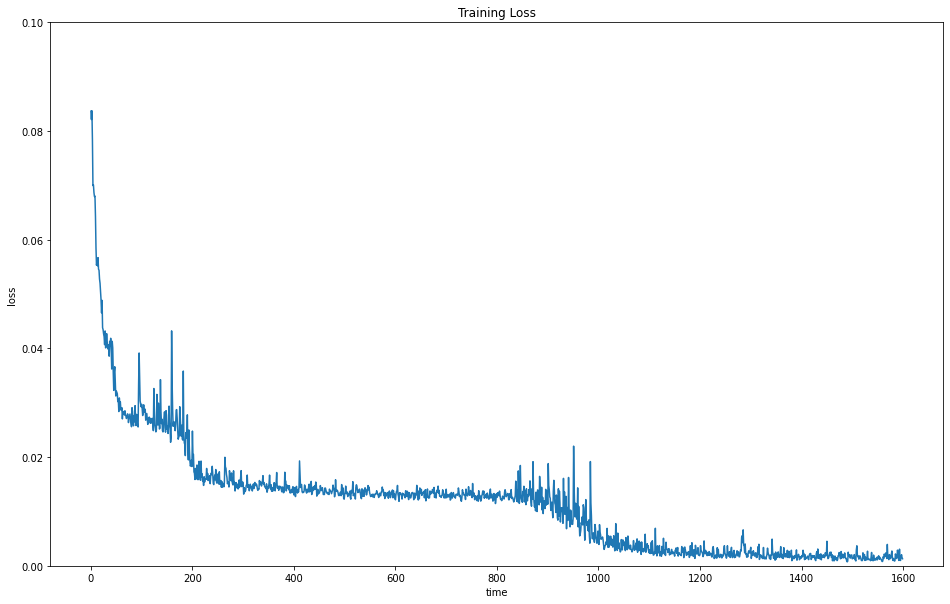

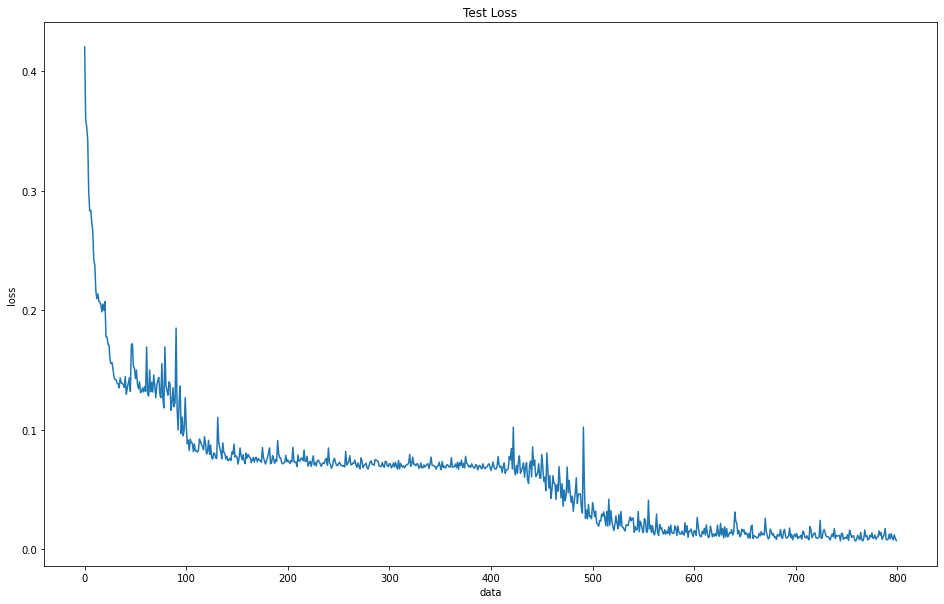

In [7]:
### Plot results
plt.figure(figsize=(16,10))
plt.plot(loss_list)
axes = plt.gca()
plt.title('Training Loss')
plt.xlabel('time')
plt.ylabel('loss')
axes.set_ylim([0,0.1])
plt.show()

plt.figure(figsize=(16,10))
plt.plot(test_loss_list)
axes = plt.gca()
plt.title('Test Loss')
plt.xlabel('data')
plt.ylabel('loss')
# axes.set_ylim([0.06,0.09])
plt.show()

In [8]:
### Save the trained model
# torch.save(model.state_dict(), '800_ep_good.pth')

### Load a trained model
# model = models.vgg16() # we do not specify pretrained=True, i.e. do not load default weights
# model.load_state_dict(torch.load('model_weights.pth'))
# model.eval()

In [9]:
### Generate random trial from test data

n = np.random.randint(0,int(0.2*data_trials))
pred=model(x_test_tensor[n])
print("predicted a: ", pred[0])
# print("actual q: ", x_test_tensor[n])
# print(y_test_tensor[n])
print("difference between predicted and actual a's: ", abs(pred[0]-y_test_tensor[n]))

predicted a:  tensor([0.8957, 0.0387, 0.6072, 0.4033, 0.7077, 0.6708],
       grad_fn=<SelectBackward>)
difference between predicted and actual a's:  tensor([0.0107, 0.0273, 0.0017, 0.1031, 0.0237, 0.0305], grad_fn=<AbsBackward>)


In [10]:
### Compare predicted q to actual q
from gekko import GEKKO



### get a, q from above
a = pred[0].cpu().detach().numpy()
q_actual = x_test_tensor[n].cpu().detach().numpy()

##################################################
### Equations for mu's ###########################
##################################################

m = GEKKO()            # create GEKKO model

# define parameters
c1 = 1.0
c2 = 1.0
c3 = 1.0
t_steps = 100
m.time = np.linspace(0,1,t_steps) # t range [0,1]
t = m.Param(value=m.time)

# define variables
# initial conditions mu(0) = a
mu1 = m.Var(value=a[0])
mu2 = m.Var(value=a[1])
mu3 = m.Var(value=a[2])
mu4 = m.Var(value=a[3])
mu5 = m.Var(value=a[4])
mu6 = m.Var(value=a[5])

# define equations
m.Equation(mu1.dt() == (c3**-1)*mu3*mu2 - (c2**-1)*mu2*mu3)
m.Equation(mu2.dt() == mu6 + (c1**-1)*mu1*mu3 - (c3**-1)*mu3*mu1)
m.Equation(mu3.dt() == -mu5 + (c2**-1)*mu2*mu1 - (c1**-1)*mu1*mu2)
m.Equation(mu4.dt() == (c3**-1)*mu3*mu5 - (c2**-1)*mu2*mu6)
m.Equation(mu5.dt() == (c1**-1)*mu1*mu6 - (c3**-1)*mu3*mu4)
m.Equation(mu6.dt() == (c2**-1)*mu2*mu4 - (c1**-1)*mu1*mu5)


##################################################
### Equations for q's ############################
##################################################

# define variables
# initial condition q(0) = I
q11 = m.Var(value = 1.0)
q12 = m.Var(value = 0.0)
q13 = m.Var(value = 0.0)
q14 = m.Var(value = 0.0)
q21 = m.Var(value = 0.0)
q22 = m.Var(value = 1.0)
q23 = m.Var(value = 0.0)
q24 = m.Var(value = 0.0)
q31 = m.Var(value = 0.0)
q32 = m.Var(value = 0.0)
q33 = m.Var(value = 1.0)
q34 = m.Var(value = 0.0)
q41 = m.Var(value = 0.0)
q42 = m.Var(value = 0.0)
q43 = m.Var(value = 0.0)
q44 = m.Var(value = 1.0)

# define equations
m.Equation(q11.dt() == q12*(mu3/c3) - q13*(mu2/c2))
m.Equation(q21.dt() == q22*(mu3/c3) - q23*(mu2/c2))
m.Equation(q31.dt() == q32*(mu3/c3) - q33*(mu2/c2))
m.Equation(q41.dt() == q42*(mu3/c3) - q43*(mu2/c2))
m.Equation(q12.dt() == -q12*(mu3/c3) + q14*(mu1/c1))
m.Equation(q22.dt() == -q22*(mu3/c3) + q24*(mu1/c1))
m.Equation(q32.dt() == -q32*(mu3/c3) + q34*(mu1/c1))
m.Equation(q42.dt() == -q42*(mu3/c3) + q44*(mu1/c1))
m.Equation(q13.dt() == q11*(mu2/c2) - q12*(mu1/c1))
m.Equation(q23.dt() == q21*(mu2/c2) - q22*(mu1/c1))
m.Equation(q33.dt() == q31*(mu2/c2) - q32*(mu1/c1))
m.Equation(q43.dt() == q41*(mu2/c2) - q42*(mu1/c1))
m.Equation(q14.dt() == q11)
m.Equation(q24.dt() == q21)
m.Equation(q34.dt() == q31)
m.Equation(q44.dt() == q41)



##################################################
### Solve Equations ##############################
##################################################
m.options.IMODE=4
m.solve(disp=False)

q = [q11, q12, q13, q14, q21, q22, q23, q24, q31, q32, q33, q34, q41, q42, q43, q44]
#     print("a=",a)
#     print("q=",q)

# Print
print('a =', a[0], a[1], a[2], a[3], a[4], a[5])
print('b =', q14[-1], q24[-1], q34[-1])
print(" ")


a = 0.89571446 0.038678832 0.6072198 0.40330124 0.70768255 0.6708347
b = 0.99763041522 0.19359909327 -0.10707904478
 


MSE =  1.6263932040166034e-05


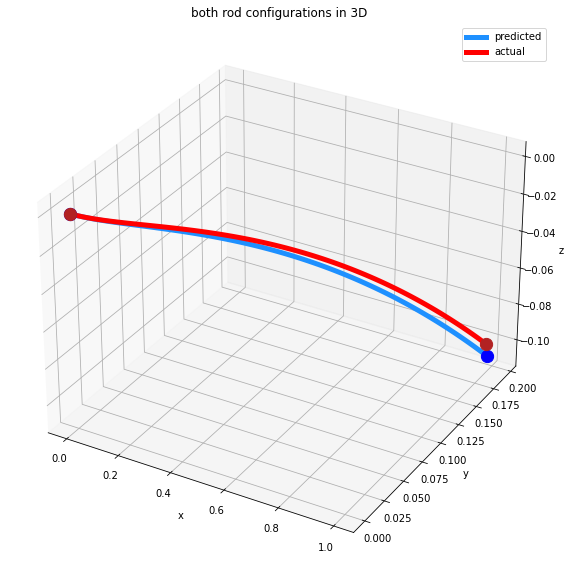

In [11]:
### plot the initial trajectory in 3D
from mpl_toolkits import mplot3d

### Interpret q's
x = [q14[i] for i in range(t_steps)]
y = [q24[i] for i in range(t_steps)]
z = [q34[i] for i in range(t_steps)]

x_actual = [q_actual[0][3][i] for i in range(t_steps)]
y_actual = [q_actual[0][7][i] for i in range(t_steps)]
z_actual = [q_actual[0][11][i] for i in range(t_steps)]

MSE = np.square(np.subtract(q_actual[0][:][:],q)).mean()
print("MSE = ", MSE)

### 3D plot
### Predicted
# fig0 = plt.figure(figsize = (12,10))
# ax0 = plt.axes(projection ='3d')
# ax0.scatter(x[0], y[0], z[0], marker='o', s=150, color='blue')
# ax0.scatter(x[-1], y[-1], z[-1], marker='o', s=150, color='blue')
# ax0.set_title('predicted rod configuration in 3D')
# ax0.set_xlabel('x')
# ax0.set_ylabel('y')
# ax0.set_zlabel('z')
# ax0.plot3D(x, y, z, color='dodgerblue', linewidth=5, label='predicted')
# plt.legend()

### Actual
# fig1 = plt.figure(figsize = (12,10))
# ax1 = plt.axes(projection ='3d')
# ax1.scatter(x_actual[0], y_actual[0], z_actual[0], marker='o', s=150, color='firebrick')
# ax1.scatter(x_actual[-1], y_actual[-1], z_actual[-1], marker='o', s=150, color='firebrick')
# ax1.set_title('actual rod configuration in 3D')
# ax1.set_xlabel('x')
# ax1.set_ylabel('y')
# ax1.set_zlabel('z')
# ax1.plot3D(x_actual, y_actual, z_actual, color='red', linewidth=5, label='actual')
# plt.legend()

### Both
fig1 = plt.figure(figsize = (12,10))
ax1 = plt.axes(projection ='3d')
ax1.scatter(x[0], y[0], z[0], marker='o', s=150, color='blue')
ax1.scatter(x[-1], y[-1], z[-1], marker='o', s=150, color='blue')
ax1.scatter(x_actual[0], y_actual[0], z_actual[0], marker='o', s=150, color='firebrick')
ax1.scatter(x_actual[-1], y_actual[-1], z_actual[-1], marker='o', s=150, color='firebrick')
ax1.set_title('both rod configurations in 3D')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.plot3D(x, y, z, color='dodgerblue', linewidth=5, label='predicted')
ax1.plot3D(x_actual, y_actual, z_actual, color='red', linewidth=5, label='actual')
plt.legend()